In [1]:
%matplotlib inline
from astropy.io import fits
from matplotlib import pyplot as plt
from numpy import *
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import IsolationForest as IF
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import os, sys

In [2]:
class fits_cat:
    def __init__(self, fitsfile):
        self.fits_name = fitsfile
        self.fits_file = fits.open(self.fits_name)
        self.header = self.fits_file[1].header
        self.catalog = self.fits_file[1].data
        self.stationary0 = self.catalog[self.catalog['MATCHES'] > 0]
        self.stationary1 = self.catalog[self.catalog['MATCHES'] > 1]
        self.stationary2 = self.catalog[self.catalog['MATCHES'] > 2]
        self.ns = self.catalog[logical_and(self.catalog['MATCHES'] == 0, self.catalog['OVERLAPS'] >1)]
        self.ns1 = self.catalog[logical_and(self.catalog['MATCHES'] == 0, self.catalog['OVERLAPS'] >2)]
        self.real_feature = self.feature(self.stationary2)
        self.ns_feature = self.feature(self.ns1)
    def plot(self):
        #plt.xlim(165.5, 168.0)
        #plt.ylim(31.5, 32.0)
        #plt.xlim(165, 168.0)
        #plt.plot(self.stationary0['X_WORLD'], self.stationary0['Y_WORLD'], '.', label='MATCH >0')
        #plt.plot(self.stationary1['X_WORLD'], self.stationary1['Y_WORLD'], '.', label='MATCH >1')
        #plt.plot(self.ns['X_WORLD'], self.ns['Y_WORLD'], '.', label='NS, OVERLAPS >1')
        #plt.plot(self.ns1['X_WORLD'], self.ns1['Y_WORLD'], '.', label='NS, OVERLAPS >2')
        plt.plot(self.catalog['X_WORLD'], self.catalog['Y_WORLD'], marker = '.', label='ALL')
        plt.legend(loc=2)
    def feature(self, cat):
        return array([cat['MAG_ISO'], cat['MAGERR_ISO'], cat['MAG_ISOCOR'], cat['MAGERR_ISOCOR'], 
                       cat['MAG_APER'], cat['MAGERR_APER'], cat['MAG_AUTO'], cat['MAGERR_AUTO'],
                       cat['MAG_PETRO'], cat['MAGERR_PETRO'], cat['MAG_WIN'], cat['MAGERR_WIN'],
                       cat['SNR_WIN'], cat['MAG_SOMFIT'], cat['MAGERR_SOMFIT'], cat['KRON_RADIUS'],
                       cat['PETRO_RADIUS'], cat['BACKGROUND'], cat['ISOAREA_IMAGE'], cat['ISOAREAF_IMAGE'],
                       cat['A_IMAGE'], cat['B_IMAGE'], cat['THETA_IMAGE'], cat['ERRX2_IMAGE'],
                       cat['ERRY2_IMAGE'], cat['ERRXY_IMAGE'], cat['ERRCXX_IMAGE'], cat['ERRCYY_IMAGE'],
                       cat['ERRCXY_IMAGE'], cat['CXXWIN_IMAGE'], cat['CYYWIN_IMAGE'], cat['CXYWIN_IMAGE'],
                       cat['AWIN_IMAGE'], cat['BWIN_IMAGE'], cat['ERRX2WIN_IMAGE'], cat['ERRY2WIN_IMAGE'],
                       cat['ERRXYWIN_IMAGE'], cat['ERRCXXWIN_IMAGE'], cat['ERRCYYWIN_IMAGE'], cat['ERRCXYWIN_IMAGE'],
                       cat['MU_THRESHOLD'], cat['MU_MAX'], cat['ISO0'], cat['ISO1'], cat['ISO2'], cat['ISO3'],
                       cat['ISO4'], cat['ISO5'], cat['ISO6'], cat['ISO7'], cat['FWHM_IMAGE'], cat['ELONGATION'],
                       cat['ELLIPTICITY'], cat['POLAR_IMAGE'], cat['POLARWIN_IMAGE'], cat['FLUX_RADIUS'], 
                       cat['FWHMPSF_IMAGE'], cat['MAG_PSF'], cat['MAGERR_PSF'], cat['CHI2_PSF'],
                       cat['ERRCXXPSF_IMAGE'], cat['ERRCYYPSF_IMAGE'], cat['ERRCXYPSF_IMAGE'],
                       cat['ERRAPSF_IMAGE'], cat['ERRBPSF_IMAGE'], cat['ERRAPSF_WORLD'], cat['ERRBPSF_WORLD'],
                       cat['ERRTHETAPSF_SKY']]).T
        

752312 592427 446362 652719 559270


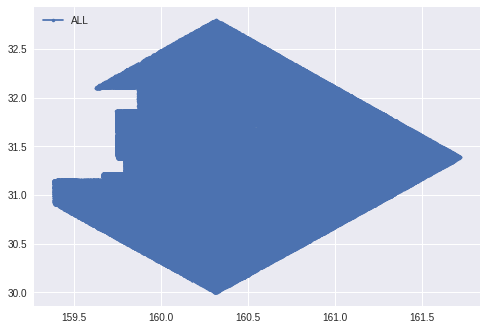

In [3]:
test0 = fits_cat('HPX_02937_RA_160.3_DEC_+31.4_cat.fits')
print len(test0.stationary0), len(test0.stationary1), len(test0.stationary2), len(test0.ns), len(test0.ns1)
test0.plot()

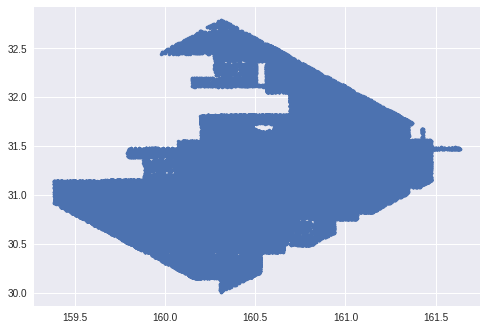

In [4]:
plt.plot(test0.stationary2['X_WORLD'], test0.stationary2['Y_WORLD'], '.',  label = 'stationary')

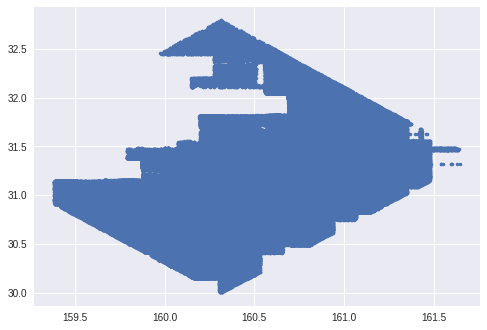

In [5]:
plt.plot(test0.ns1['X_WORLD'], test0.ns1['Y_WORLD'],'.', label='ns')

In [6]:
class IF_real_bogus:
    def __init__(self, feature):
        self.feature = feature
        #self.Class = []
        #[self.Class.append('real') for i in range(len(self.feature))]
        #self.trainning, self.test, self.Class_train, self.Class_test = train_test_split(self.real_feature,\
        #                        self.real_Class, test_size=0.4, random_state=0)
        #print self.trainning     
    def train(self):
        self.IFmod = IF(n_estimators = 160)
        self.IFmod.fit(self.feature)
        
    def validation(self):
        #score = self.IFmod.decision_function(self.feature)
        result = self.IFmod.predict(self.feature)
        self.normal = (result == 1)
        self.abnormal = (result == -1)
        print "total:{0}, normal:{1}, abnormal:{2}, total/normal:{3}".format(len(self.feature), 
                self.normal.sum(), self.abnormal.sum(), self.normal.sum()/float(len(self.feature)))

In [7]:
#this is the test set
IF0 = IF_real_bogus(test0.real_feature) 
IF0.train()
IF0.validation()

total:446362, normal:401725, abnormal:44637, total/normal:0.899998207733


In [8]:
#the same healpix, but non-stationary sources
IF1 = IF_real_bogus(test0.ns_feature)
IF1.IFmod = IF0.IFmod
IF1.validation()

total:559270, normal:88840, abnormal:470430, total/normal:0.158849929372


In [9]:
#.normal is the mask for real normal sources selection
IF1.normal

array([False,  True, False, ...,  True,  True,  True], dtype=bool)

# RA, DEC distribution of "normal" ns sources 

/home/edlin/anaconda2/lib/python2.7/site-packages/numpy/core/records.py:499: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652719 but corresponding boolean dimension is 559270
  obj = super(recarray, self).__getitem__(indx)
/home/edlin/anaconda2/lib/python2.7/site-packages/astropy/io/fits/fitsrec.py:502: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652719 but corresponding boolean dimension is 559270
  arrays.append(self._coldefs._arrays[idx][key])


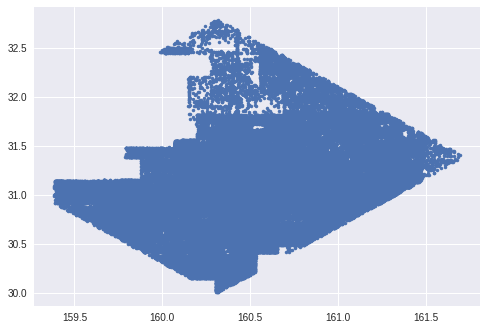

In [10]:
ra= test0.ns[IF1.normal]['X_WORLD']
dec = test0.ns[IF1.normal]['Y_WORLD']
#plt.xlim(166., 166.2)
#plt.ylim(31.9, 32.1)
plt.plot(ra, dec, '.')

# RA, DEC distribution of "false (abnormal)" ns sources 

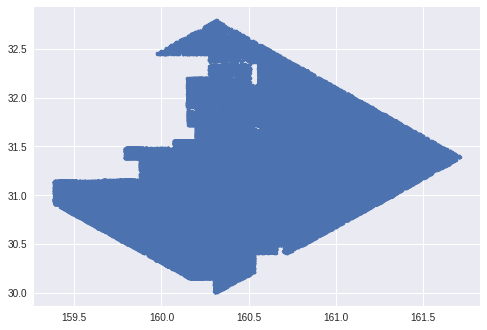

In [11]:
ra= test0.ns[IF1.abnormal]['X_WORLD']
dec = test0.ns[IF1.abnormal]['Y_WORLD']
#plt.xlim(166., 166.2)
#plt.ylim(31.9, 32.1)
plt.plot(ra, dec, '.')

# stationary sources mag vs mag_err (phot, blue: normal, green: abnormal)

401725 44637


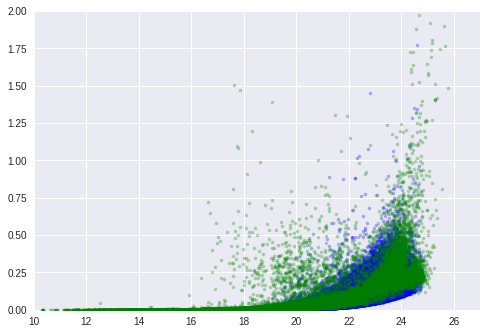

In [12]:
mag_n= test0.stationary2[IF0.normal]['MAG_AUTO']
mag_n_err = test0.stationary2[IF0.normal]['MAGERR_AUTO']
mag_a= test0.stationary2[IF0.abnormal]['MAG_AUTO']
mag_a_err = test0.stationary2[IF0.abnormal]['MAGERR_AUTO']
plt.xlim(10., 27.)
plt.ylim(0, 2)
plt.plot(mag_n, mag_n_err, '.', alpha=0.3, color='blue')
plt.plot(mag_a, mag_a_err, '.', alpha=0.3, color='green')
print len(mag_n), len(mag_a)

# stationary sources mag histogram (blue: normal, green: abnormal)

(array([  3.17428827e-04,   4.36464636e-04,   2.61878782e-03,
          3.37268128e-03,   8.80864994e-03,   1.07132229e-02,
          1.67443706e-02,   2.47991271e-02,   3.56710644e-02,
          3.80914592e-02,   5.71371888e-02,   7.10643785e-02,
          9.28876104e-02,   1.23281420e-01,   1.51294514e-01,
          1.78672751e-01,   1.97480409e-01,   1.40819363e-01,
          9.30860034e-02,   5.52722944e-02,   3.66630295e-02,
          3.26158119e-02,   5.55103660e-02,   1.51770658e-01,
          1.29629997e-01,   4.84078960e-02,   6.22954072e-03,
          9.52286480e-04,   2.77750223e-04,   7.93572066e-05]),
 array([ 10.        ,  10.56666667,  11.13333333,  11.7       ,
         12.26666667,  12.83333333,  13.4       ,  13.96666667,
         14.53333333,  15.1       ,  15.66666667,  16.23333333,
         16.8       ,  17.36666667,  17.93333333,  18.5       ,
         19.06666667,  19.63333333,  20.2       ,  20.76666667,
         21.33333333,  21.9       ,  22.46666667,  23.0333

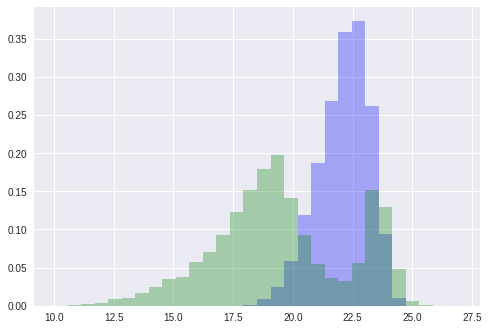

In [13]:
plt.hist(mag_n, bins =30, range=(10,27), normed=1, facecolor='blue', alpha=0.3)
plt.hist(mag_a, bins =30, range=(10,27), normed=1, facecolor='green', alpha=0.3)

# abnormal sources mag vs mag_err (blue: stationary, green: non-stationary)

44637 470430


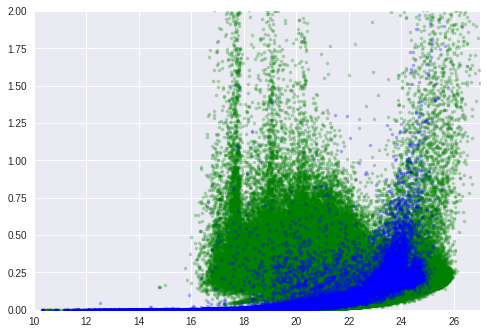

In [14]:
mag_n= test0.stationary2[IF0.abnormal]['MAG_AUTO']
mag_n_err = test0.stationary2[IF0.abnormal]['MAGERR_AUTO']
mag_a= test0.ns1[IF1.abnormal]['MAG_AUTO']
mag_a_err = test0.ns1[IF1.abnormal]['MAGERR_AUTO']
plt.xlim(10., 27.)
plt.ylim(0, 2)
plt.plot(mag_a, mag_a_err, '.', alpha=0.3, color='green')
plt.plot(mag_n, mag_n_err, '.', alpha=0.3, color='blue')
print len(mag_n), len(mag_a)

# normal sources mag vs mag_err (blue: stationary, green: non-stationary)

401725 88840


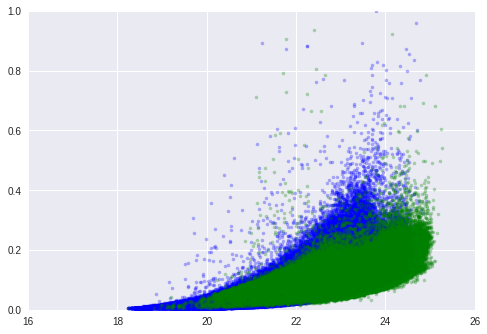

In [15]:
mag_n= test0.stationary2[IF0.normal]['MAG_AUTO']
mag_n_err = test0.stationary2[IF0.normal]['MAGERR_AUTO']
mag_a= test0.ns1[IF1.normal]['MAG_AUTO']
mag_a_err = test0.ns1[IF1.normal]['MAGERR_AUTO']
plt.xlim(16., 26.)
plt.ylim(0, 1)
plt.plot(mag_n, mag_n_err, '.', alpha=0.3, color='blue')
plt.plot(mag_a, mag_a_err, '.', alpha=0.3, color='green')
print len(mag_n), len(mag_a)

(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.98638663e-05,
          7.94554652e-05,   8.54146251e-04,   3.01930768e-03,
          6.21739015e-02,   2.09027465e-01,   2.03525174e-01,
          1.71742988e-01,   1.66479063e-01,   2.47960643e-01,
          3.59218158e-01,   3.08545435e-01,   3.20602802e-02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 10.        ,  10.56666667,  11.13333333,  11.7       ,
         12.26666667,  12.83333333,  13.4       ,  13.96666667,
         14.53333333,  15.1       ,  15.66666667,  16.23333333,
         16.8       ,  17.36666667,  17.93333333,  18.5       ,
         19.06666667,  19.63333333,  20.2       ,  20.76666667,
         21.33333333,  21.9       ,  22.46666667,  23.0333

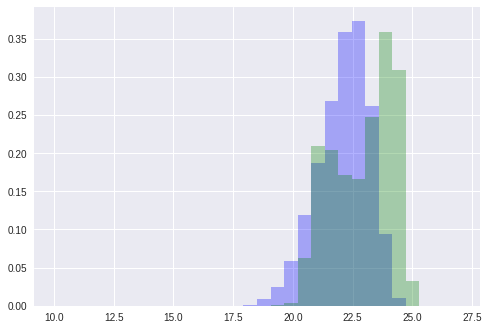

In [16]:
plt.hist(mag_n, bins =30, range=(10,27), normed=1, facecolor='blue', alpha=0.3)
plt.hist(mag_a, bins =30, range=(10,27), normed=1, facecolor='green', alpha=0.3)

# normal/abnormal stationary sources histograms

(array([  8.94789037e-03,   6.68274432e-02,   3.00802380e-01,
          1.92390912e-01,   4.21700325e-02,   5.69554634e-02,
          7.13351965e-02,   7.15605842e-02,   5.93896502e-02,
          3.97583844e-02,   2.51532636e-02,   1.77830869e-02,
          1.23061666e-02,   8.69996394e-03,   6.15308330e-03,
          4.73314100e-03,   3.47097007e-03,   2.41164803e-03,
          2.18626037e-03,   1.41994230e-03,   8.79011900e-04,
          1.10439957e-03,   7.88856834e-04,   6.08546700e-04,
          4.05697800e-04,   3.83159034e-04,   2.02848900e-04,
          3.60620267e-04,   4.05697800e-04,   4.05697800e-04]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.]),
 <a list of 30 Patch objects>)

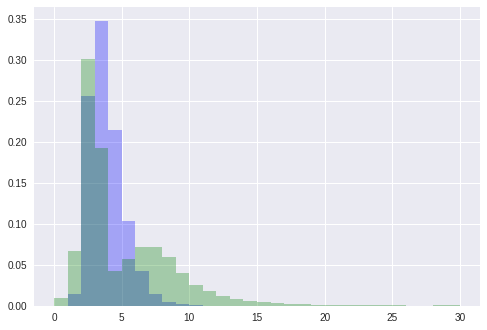

In [17]:
frad_n= test0.stationary2[IF0.normal]['FLUX_RADIUS']
frad_a= test0.stationary2[IF0.abnormal]['FLUX_RADIUS']
plt.hist(frad_n, bins =30, range=(0,30), normed=1, facecolor='blue', alpha=0.3)
plt.hist(frad_a, bins =30, range=(0,30), normed=1, facecolor='green', alpha=0.3)

# normal/abnormal non-stationary sources histograms (shape)

(array([  5.37899959e-01,   1.54145586e-01,   7.76765244e-02,
          3.91899920e-02,   4.70674528e-02,   3.97283102e-02,
          3.14090425e-02,   2.32935207e-02,   1.54954136e-02,
          9.83771101e-03,   5.98798542e-03,   4.37732029e-03,
          3.51086395e-03,   2.71303781e-03,   1.89376473e-03,
          1.46482595e-03,   1.11738553e-03,   7.93536750e-04,
          5.51186337e-04,   4.33228172e-04,   3.75321436e-04,
          2.61652658e-04,   1.86588371e-04,   1.52273268e-04,
          1.09379390e-04,   9.22218386e-05,   7.50642872e-05,
          6.00514298e-05,   5.14726541e-05,   4.93279602e-05]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.]),
 <a list of 30 Patch objects>)

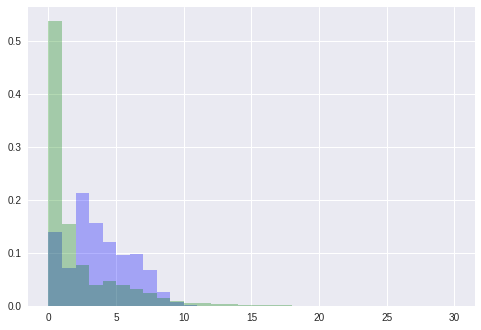

In [18]:
frad_n= test0.ns1[IF1.normal]['FLUX_RADIUS']
frad_a= test0.ns1[IF1.abnormal]['FLUX_RADIUS']
plt.hist(frad_n, bins =30, range=(0,30), normed=1, facecolor='blue', alpha=0.3)
plt.hist(frad_a, bins =30, range=(0,30), normed=1, facecolor='green', alpha=0.3)

# normal stationary and ns sources

(array([  1.39811467e-01,   7.17077181e-02,   2.13602730e-01,
          1.56907795e-01,   1.20507709e-01,   9.66426777e-02,
          9.75211452e-02,   6.80249124e-02,   2.59823631e-02,
          7.02773930e-03,   1.53168677e-03,   5.29332928e-04,
          1.35148833e-04,   3.37872082e-05,   0.00000000e+00,
          0.00000000e+00,   1.12624027e-05,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.12624027e-05,
          0.00000000e+00,   1.12624027e-05,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.]),
 <a list of 30 Patch objects>)

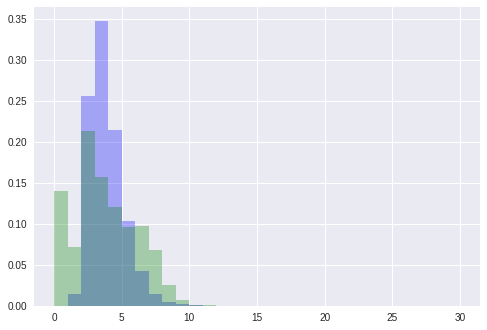

In [19]:
frad_n= test0.stationary2[IF0.normal]['FLUX_RADIUS']
frad_a= test0.ns1[IF1.normal]['FLUX_RADIUS']
plt.hist(frad_n, bins =30, range=(0,30), normed=1, facecolor='blue', alpha=0.3)
plt.hist(frad_a, bins =30, range=(0,30), normed=1, facecolor='green', alpha=0.3)

# correlation matrix (normal stationary)

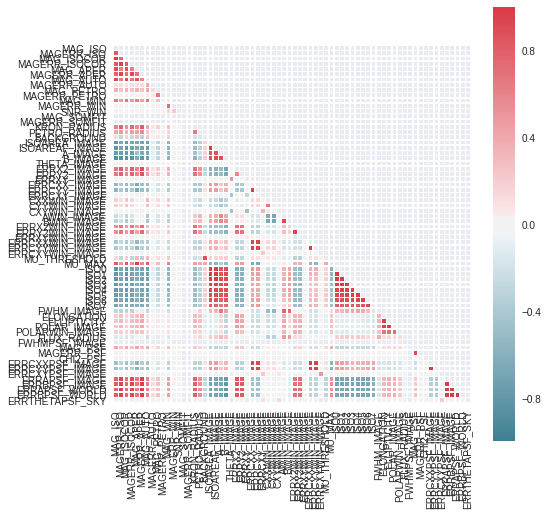

In [20]:
label = ['MAG_ISO', 'MAGERR_ISO', 'MAG_ISOCOR','MAGERR_ISOCOR', 
        'MAG_APER', 'MAGERR_APER', 'MAG_AUTO', 'MAGERR_AUTO',
        'MAG_PETRO', 'MAGERR_PETRO', 'MAG_WIN', 'MAGERR_WIN',
        'SNR_WIN', 'MAG_SOMFIT', 'MAGERR_SOMFIT', 'KRON_RADIUS',
        'PETRO_RADIUS', 'BACKGROUND', 'ISOAREA_IMAGE', 'ISOAREAF_IMAGE',
        'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'ERRX2_IMAGE',
        'ERRY2_IMAGE', 'ERRXY_IMAGE', 'ERRCXX_IMAGE', 'ERRCYY_IMAGE',
        'ERRCXY_IMAGE', 'CXXWIN_IMAGE', 'CYYWIN_IMAGE', 'CXYWIN_IMAGE',
        'AWIN_IMAGE', 'BWIN_IMAGE', 'ERRX2WIN_IMAGE', 'ERRY2WIN_IMAGE',
        'ERRXYWIN_IMAGE', 'ERRCXXWIN_IMAGE', 'ERRCYYWIN_IMAGE', 'ERRCXYWIN_IMAGE',
        'MU_THRESHOLD', 'MU_MAX', 'ISO0', 'ISO1', 'ISO2', 'ISO3',
        'ISO4', 'ISO5', 'ISO6', 'ISO7', 'FWHM_IMAGE', 'ELONGATION',
        'ELLIPTICITY', 'POLAR_IMAGE', 'POLARWIN_IMAGE', 'FLUX_RADIUS', 
        'FWHMPSF_IMAGE', 'MAG_PSF', 'MAGERR_PSF', 'CHI2_PSF',
        'ERRCXXPSF_IMAGE', 'ERRCYYPSF_IMAGE', 'ERRCXYPSF_IMAGE',
        'ERRAPSF_IMAGE', 'ERRBPSF_IMAGE', 'ERRAPSF_WORLD', 'ERRBPSF_WORLD',
        'ERRTHETAPSF_SKY']
fig, ax = plt.subplots(figsize=(8,8)) 
d0 = pd.DataFrame(data = test0.real_feature[IF0.normal], columns = label)
corr0 = d0.corr()
mask0 = zeros_like(corr0, dtype=bool)
mask0[triu_indices_from(mask0)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr0, mask=mask0, cmap=cmap, vmin = -1, vmax=1,
             square=True, linewidths=.5, cbar=1, ax = ax)

# abnormal stationary

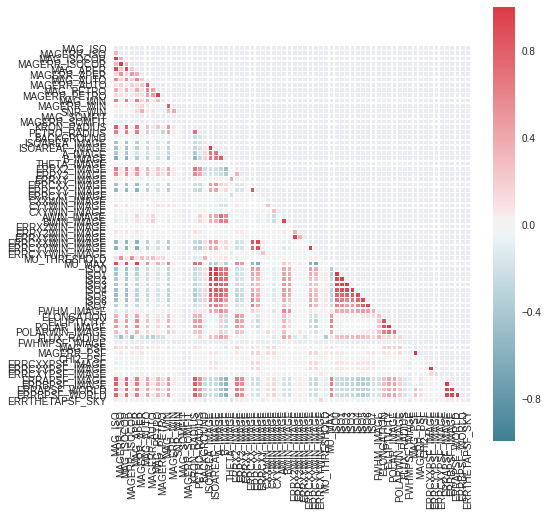

In [21]:
d1 = pd.DataFrame(data = test0.real_feature[IF0.abnormal], columns = label)
fig, ax = plt.subplots(figsize=(8,8)) 
corr1 = d1.corr()
mask1 = zeros_like(corr1, dtype=bool)
mask1[triu_indices_from(mask1)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1, mask=mask1, cmap=cmap, vmin = -1, vmax=1,
             square=True, linewidths=.5, cbar=1, ax = ax)

# normal ns

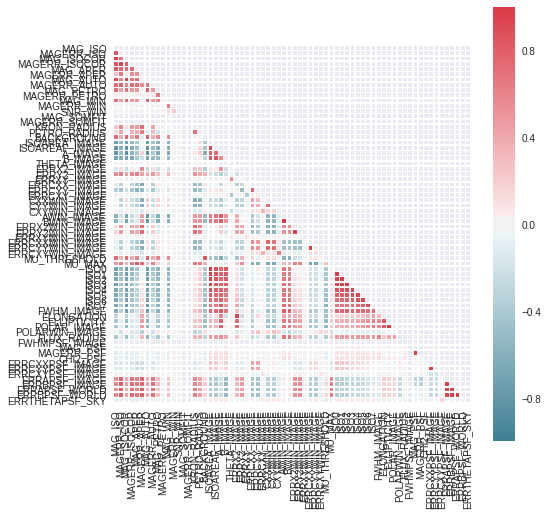

In [22]:
d1 = pd.DataFrame(data = test0.ns_feature[IF1.normal], columns = label)
fig, ax = plt.subplots(figsize=(8,8)) 
corr1 = d1.corr()
mask1 = zeros_like(corr0, dtype=bool)
mask1[triu_indices_from(mask1)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1, mask=mask1, cmap=cmap, vmin = -1, vmax=1,
             square=True, linewidths=.5, cbar=1)

# abnormal ns

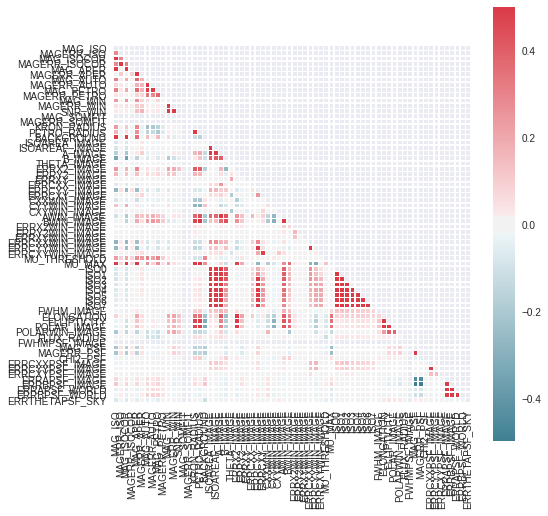

In [23]:
d1 = pd.DataFrame(data = test0.ns_feature[IF1.abnormal], columns = label)
fig, ax = plt.subplots(figsize=(8,8)) 
corr1 = d1.corr()
mask1 = zeros_like(corr0, dtype=bool)
mask1[triu_indices_from(mask1)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr1, mask=mask1, cmap=cmap, vmin = -0.5, vmax=0.5,
             square=True, linewidths=.5, cbar=1)